# Getting started with Task 2

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the root of the git repository

References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

## Load dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

## MIT-BIH  Arrhythmia Dataset

- Number of Samples: 109446
- Number of Categories: 5
- Sampling Frequency: 125Hz
- Data Source: Physionet's MIT-BIH Arrhythmia Dataset
- Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


The shape of the mitbih_train is :  (87554, 188)
The shape of the mitbih_test is :  (21892, 188)
The last time value is :  1488.0


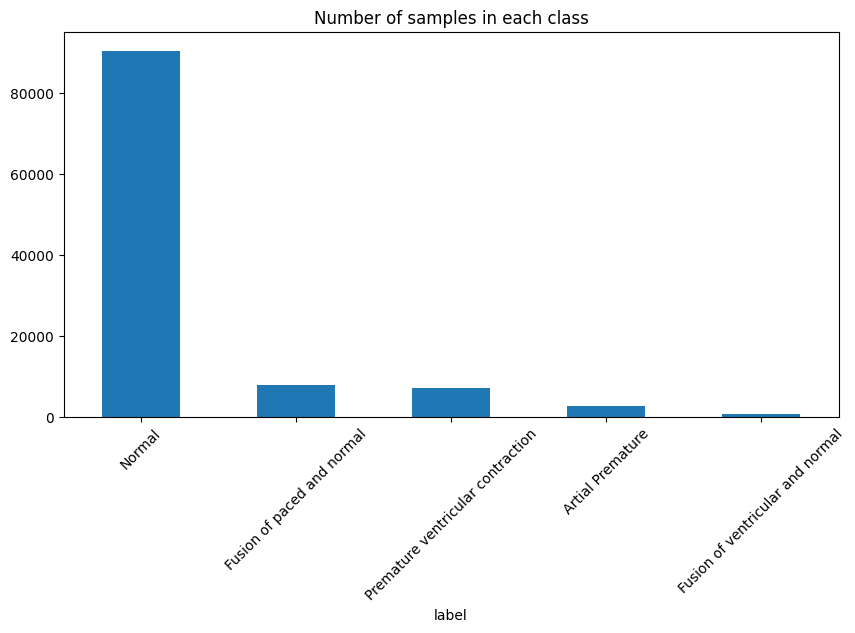

In [ ]:
df_mitbih_train = pd.read_csv("mitbih_train.csv", header = None)
df_mitbih_test = pd.read_csv("mitbih_test.csv", header = None)

# print shapes of the dataframes
print("The shape of the mitbih_train is : ", df_mitbih_train.shape)
print("The shape of the mitbih_test is : ", df_mitbih_test.shape)

df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0,ignore_index = True)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
#df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_mitbih.shape[1] - 1
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_mitbih.columns = list(time) + ["label"]

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_mitbih["label"].value_counts()
# substitute the class names
counts.index = counts.index.map(id_to_label)
# create a figure
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 45)
plt.title("Number of samples in each class")
plt.show()

<Axes: >

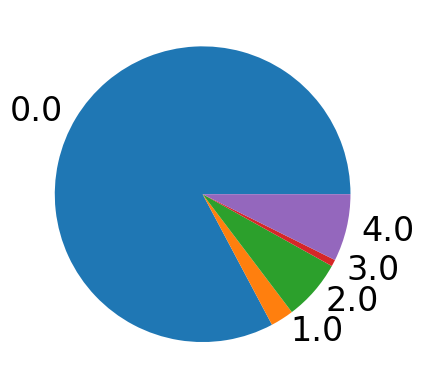

In [ ]:
df_mitbih.groupby("label").size().plot(kind='pie',
                                       y = "label", fontsize = 24)

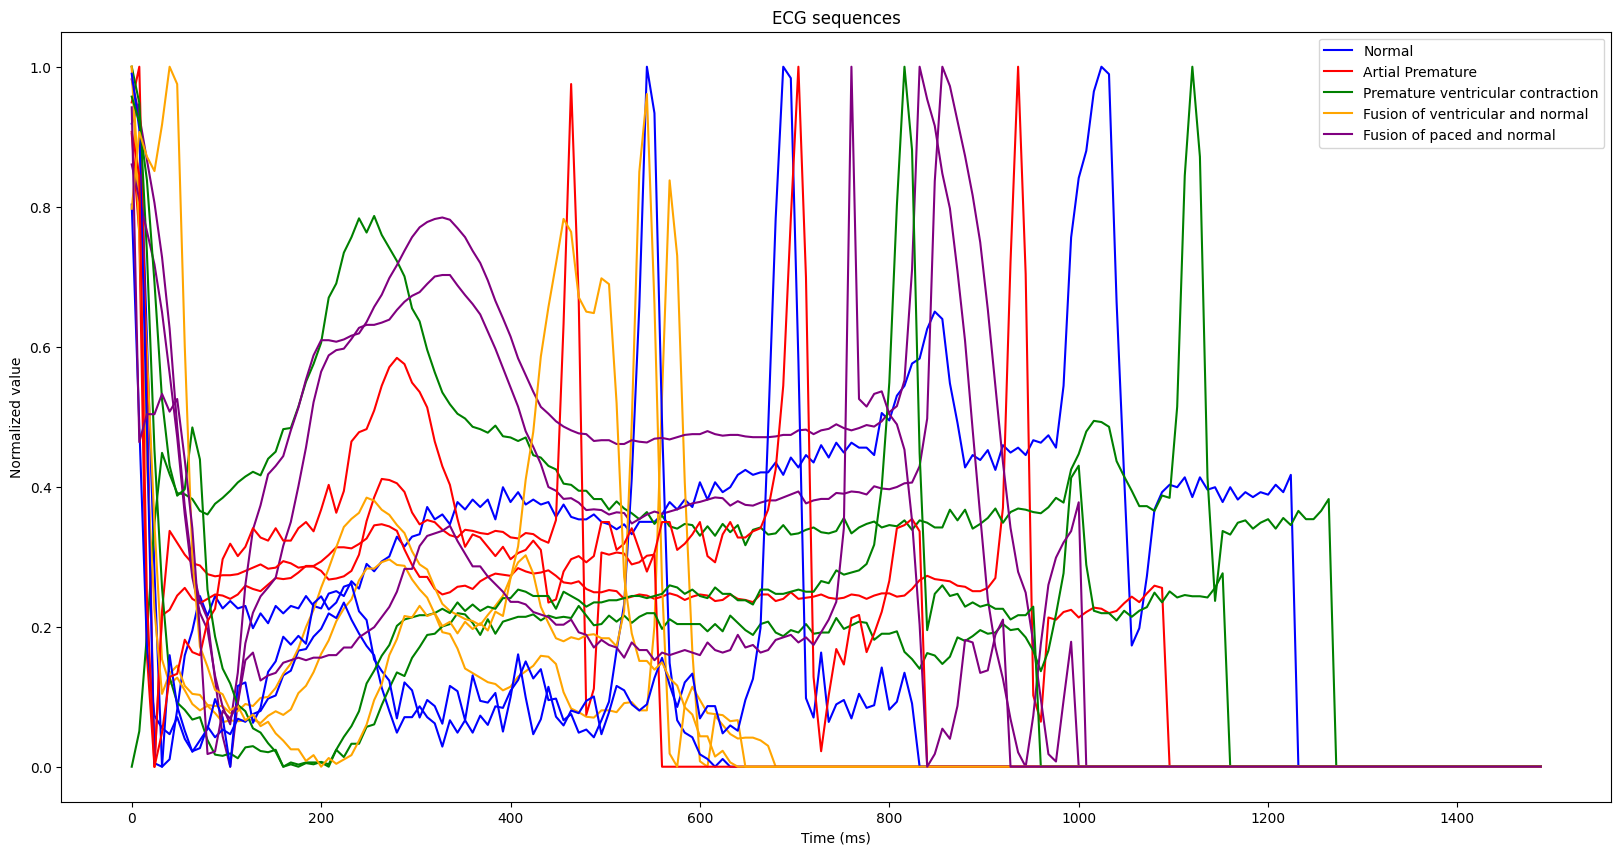

In [ ]:
# create a figure
plt.figure(figsize = (20, 10))
# define colors for each class
colors = ["blue", "red", "green", "orange", "purple"]
# plot the normal sequences
for i in range(3):
    for label in id_to_label.keys():
        # sample a random sequence from that label
        df_mitbih_label = df_mitbih[df_mitbih["label"] == label].sample(1)
        # plot the sequence
        if i == 0:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], label = id_to_label[label], color = colors[label])
        else:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], color = colors[label])
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [ ]:
df_mitbih_train, df_mitbih_test = train_test_split(df_mitbih,
                                                       shuffle = True,
                                                       random_state = 41,
                                                       test_size = .2,stratify=df_mitbih["label"])

In [ ]:
df_mitbih_tt, df_mitbih_val = train_test_split(df_mitbih_train,
                                                       shuffle = True,
                                                       random_state = 41,
                                                       test_size = .2,stratify=df_mitbih_train["label"])

In [ ]:
df_tt_resampled = pd.DataFrame(columns=df_mitbih.columns)
num_samples = 8500
for i in range(5):
  dfi = df_mitbih[(df_mitbih['label']==i)]
  df_sampled = resample(dfi, replace=True, n_samples= num_samples, random_state=41)
  df_tt_resampled = pd.concat([df_tt_resampled,df_sampled],ignore_index = True)




<ipython-input-84-44dc299a554a>:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_tt_resampled = pd.concat([df_tt_resampled,df_sampled],ignore_index = True)


In [ ]:
X_tt = df_tt_resampled.drop("label",axis=1)
y_tt = df_tt_resampled["label"]
X_val,y_val = df_mitbih_val.drop("label",axis=1),df_mitbih_val["label"]
X_test,y_test = df_mitbih_test.drop("label",axis=1),df_mitbih_test["label"]

<Axes: >

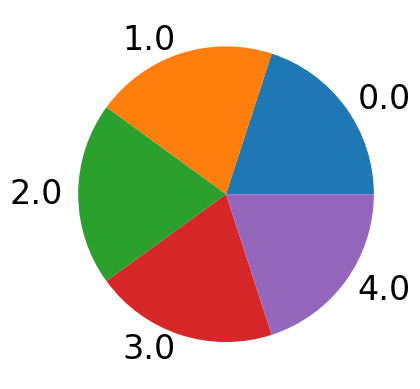

In [ ]:
df_tt_resampled.groupby("label").size().plot(kind='pie',
                                       y = "label", fontsize = 24)

In [ ]:
# KNN with Scaler

# Initialize lists for accuracy
val_scores = []

for k in range(1,20,1):
  pipeline = Pipeline([
      ('scaler', StandardScaler()),
      ('knn', KNeighborsClassifier(n_neighbors=k))
  ])

  # Train the model
  pipeline.fit(X_tt, y_tt)

  # Evaluate the model on the validation set
  val_score = f1_score(y_val,pipeline.predict(X_val),average=None)
  val_scores.append(val_score)

print(val_scores)

[array([0.96579979, 0.64275256, 0.88594784, 0.65473146, 0.97108067]), array([0.96874114, 0.64112012, 0.89705289, 0.65473146, 0.97483546]), array([0.94447067, 0.50431779, 0.84753535, 0.50393701, 0.96307575]), array([0.94940594, 0.52242424, 0.85703125, 0.49708738, 0.96319018]), array([0.93050804, 0.44524793, 0.82574332, 0.41091493, 0.9592381 ]), array([0.9368521 , 0.46529706, 0.83532588, 0.40506329, 0.96079939]), array([0.92340126, 0.41962944, 0.81313703, 0.35555556, 0.95917589]), array([0.93090802, 0.44651673, 0.8238921 , 0.35116598, 0.96052127]), array([0.91977896, 0.41607325, 0.80693816, 0.31372549, 0.9585078 ])]


In [ ]:
# KNN without normalization

val_scores = []
# Train and evaluate KNN for different values of k
for k in range(1,10,1):
  knn = KNeighborsClassifier(n_neighbors=k)

  # Train the model
  knn.fit(X_tt, y_tt)

  # Evaluate the model on the validation set
  val_score = f1_score(y_val,knn.predict(X_val),average=None)
  val_scores.append(val_score)

print(val_scores)

[array([0.96759967, 0.64992614, 0.89306698, 0.67368421, 0.9740458 ]), array([0.97034468, 0.65462754, 0.90283401, 0.67191601, 0.97447796]), array([0.94787519, 0.51563422, 0.85890993, 0.51926978, 0.96301944]), array([0.95173258, 0.52897657, 0.86580087, 0.51509054, 0.96156802]), array([0.93540828, 0.45444915, 0.84606526, 0.4317032 , 0.95585997]), array([0.94187779, 0.47981808, 0.8549081 , 0.43097643, 0.96043027]), array([0.92895008, 0.43273657, 0.83861004, 0.37101449, 0.95695238]), array([0.93624945, 0.46162465, 0.85051141, 0.36415363, 0.96239447]), array([0.92627543, 0.43125   , 0.83748056, 0.32694764, 0.95841282])]


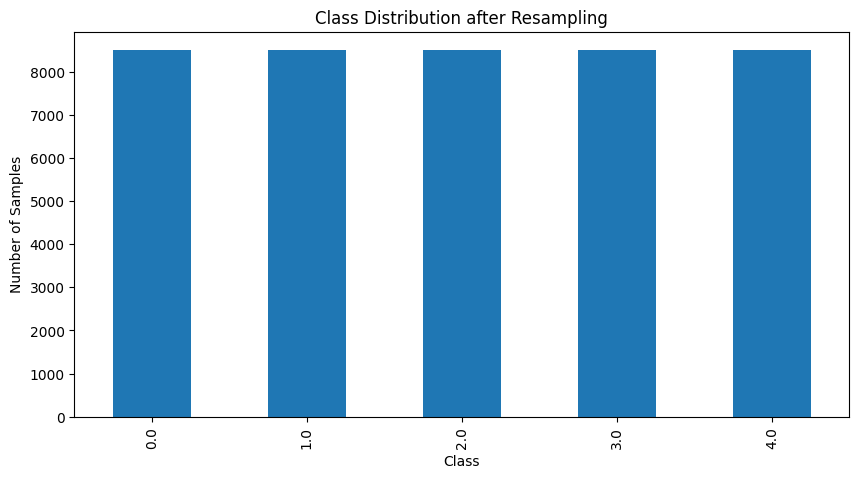

In [ ]:
# Calculate class distribution
class_distribution = df_tt_resampled['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 5))
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution after Resampling')
plt.show()

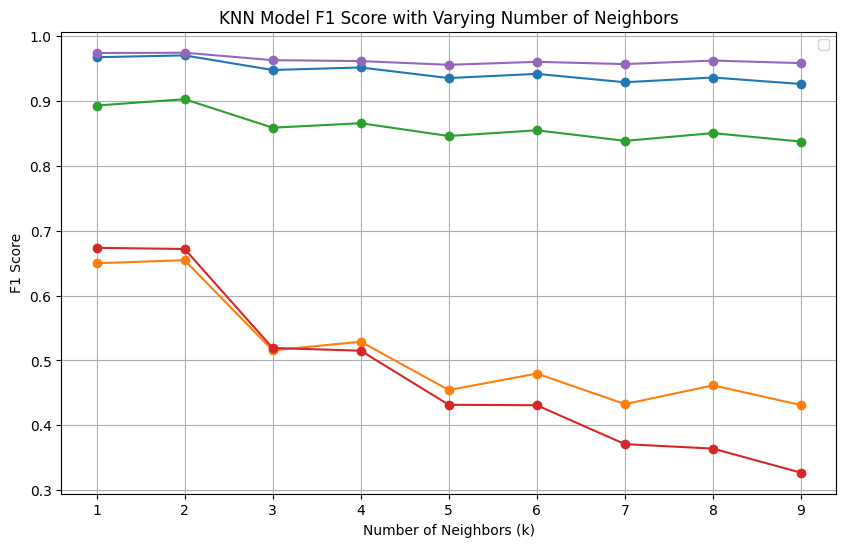

In [ ]:
n_neighbors=[1,2,3,4,5,6,7,8,9]

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors, val_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score')
plt.title('KNN Model F1 Score with Varying Number of Neighbors')
plt.legend()
plt.grid(True)
plt.show()